(moves)=

# Using different moves

One of the most important new features included in the version 3 release of emcee is the interface for using different "moves" (see {ref}`moves-user` for the API docs).
To demonstrate this interface, we'll set up a slightly contrived example where we're sampling from a mixture of two Gaussians in 1D:

In [1]:
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

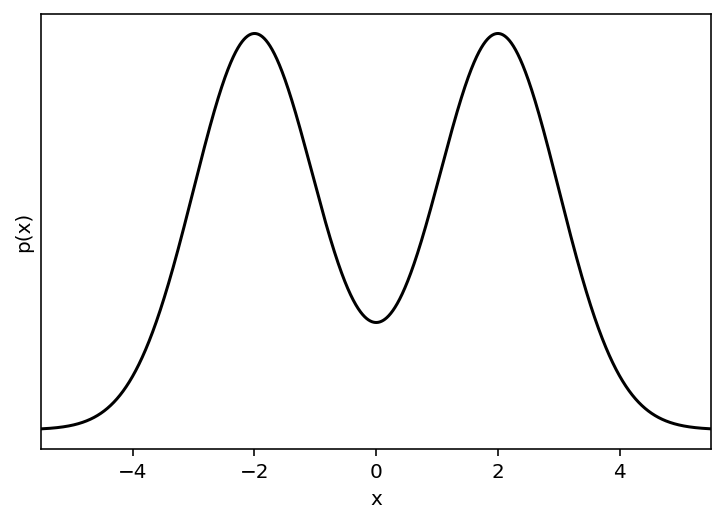

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def logprob(x):
    return np.sum(
        np.logaddexp(
            -0.5 * (x - 2) ** 2,
            -0.5 * (x + 2) ** 2,
        )
        - 0.5 * np.log(2 * np.pi)
        - np.log(2)
    )


x = np.linspace(-5.5, 5.5, 5000)
plt.plot(x, np.exp(list(map(logprob, x))), "k")
plt.yticks([])
plt.xlim(-5.5, 5.5)
plt.ylabel("p(x)")
plt.xlabel("x");

Now we can sample this using emcee and the default {class}`moves.StretchMove`:

In [3]:
import emcee

np.random.seed(589403)

init = np.random.randn(32, 1)
nwalkers, ndim = init.shape

sampler0 = emcee.EnsembleSampler(nwalkers, ndim, logprob)
sampler0.run_mcmc(init, 5000)

print("Autocorrelation time: {0:.2f} steps".format(sampler0.get_autocorr_time()[0]))

Autocorrelation time: 40.03 steps


This autocorrelation time seems long for a 1D problem!
We can also see this effect qualitatively by looking at the trace for one of the walkers:

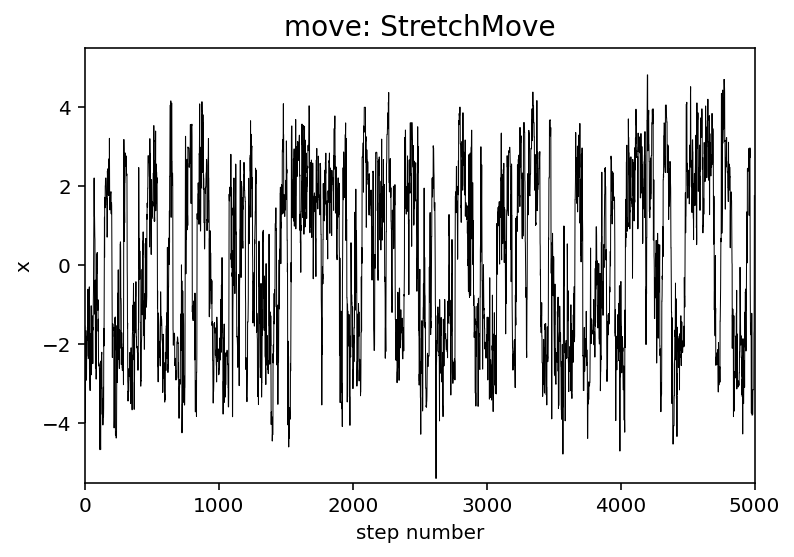

In [4]:
plt.plot(sampler0.get_chain()[:, 0, 0], "k", lw=0.5)
plt.xlim(0, 5000)
plt.ylim(-5.5, 5.5)
plt.title("move: StretchMove", fontsize=14)
plt.xlabel("step number")
plt.ylabel("x");

For "lightly" multimodal problems like these, some combination of the {class}`moves.DEMove` and {class}`moves.DESnookerMove` can often perform better than the default.
In this case, let's use a weighted mixture of the two moves.
In deatil, this means that, at each step, we'll randomly select either a :class:`moves.DEMove` (with 80% probability) or a {class}`moves.DESnookerMove` (with 20% probability).

Autocorrelation time: 6.49 steps


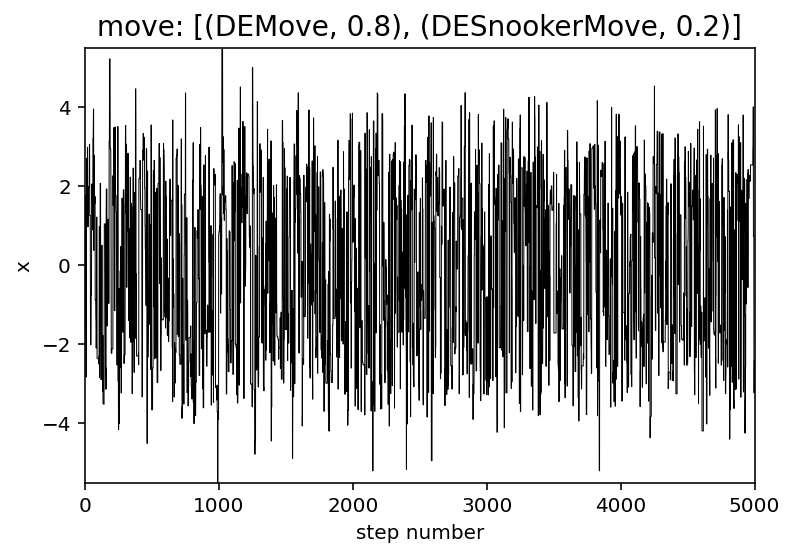

In [5]:
np.random.seed(93284)

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    logprob,
    moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ],
)
sampler.run_mcmc(init, 5000)

print("Autocorrelation time: {0:.2f} steps".format(sampler.get_autocorr_time()[0]))

plt.plot(sampler.get_chain()[:, 0, 0], "k", lw=0.5)
plt.xlim(0, 5000)
plt.ylim(-5.5, 5.5)
plt.title("move: [(DEMove, 0.8), (DESnookerMove, 0.2)]", fontsize=14)
plt.xlabel("step number")
plt.ylabel("x");

That looks a lot better!

The idea with the {ref}`moves-user` interface is that it should be easy for users to try out several different moves to find the combination that works best for their problem so you should head over to {ref}`moves-user` to see all the details!